In [862]:
import pandas as pd
import os
import numpy as np

from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.layers.experimental.preprocessing import Normalization
from keras import regularizers
from sklearn.preprocessing import Normalizer, normalize

import seaborn as sns
import matplotlib.pyplot

In [780]:
layers.Normalization

AttributeError: module 'keras.layers' has no attribute 'Normalization'

In [506]:
RANDOM_STATE = 7
PATH = 'data'
STEP_SLICE = 100

In [24]:
df = pd.read_csv('data/badminton/002-F-badminton.csv', index_col = 0)

In [25]:
df

,wx,wy,wz,nx,ny,nz,tx,ty,tz
0,12.016,-9.859,-6.479,-1.434,7.111,2.832,1.659,-0.403,5.477
1,12.099,-10.064,-7.256,-1.683,7.465,2.940,0.435,2.691,8.265
2,13.446,-10.370,-7.970,-1.986,7.855,3.133,-0.639,6.594,9.035
3,15.310,-11.010,-8.423,-2.260,8.231,3.413,-1.298,9.925,7.051
4,16.904,-10.862,-7.926,-2.410,8.230,3.591,-2.494,11.947,4.404
...,...,...,...,...,...,...,...,...,...
995,6.015,-0.589,4.991,1.794,-0.881,1.434,NaN,NaN,NaN
996,6.488,-0.834,4.969,0.400,-0.607,1.374,NaN,NaN,NaN
997,6.900,-1.213,5.120,-1.864,-0.237,0.761,NaN,NaN,NaN
998,7.017,-1.560,5.077,-3.809,0.044,0.751,NaN,NaN,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wx      1000 non-null   float64
 1   wy      1000 non-null   float64
 2   wz      1000 non-null   float64
 3   nx      1000 non-null   float64
 4   ny      1000 non-null   float64
 5   nz      1000 non-null   float64
 6   tx      700 non-null    float64
 7   ty      700 non-null    float64
 8   tz      700 non-null    float64
dtypes: float64(9)
memory usage: 78.1 KB


In [786]:
# функція повертає тензор перетворених csv файлів з каталогів та класи відповідно до каталогів
# приймає аргументами шлях, вікно та крок з яким буде розбивати дані

def data_to_numpy(path, window = 100, step_slice = 100, random_state = None, val_split = None, test_split = None):
    
    if window % step_slice != 0:
        print("\n\n!ATTENTION: not all data will be processed\n\n")
    
    #зчитування папок як таргети
    targets_title = list()
    
    for folder in os.listdir(path):
        path_folder = os.path.join(path, folder)
        if os.path.isdir(path_folder):
            targets_title.append(folder)
    
    print(f"Targets: {targets_title}")
    
    # об'єднання всіх таблиць в одну матрицю та список кінцевих класів
    data = list()
    targets = list()
    
    for target_id, target in enumerate(targets_title):
        path_list = os.listdir(os.path.join(path, target))
        print(f'Loading data: {target} - target num: {target_id}')
        n_samples = 0
        
        for file in path_list:
            
            if file[-3:] == 'csv':
                path_to_file = os.path.join(path, target, file)
                df = pd.read_csv(path_to_file, index_col = 0)
                
                if len(df) % step_slice != 0:
                    raise Exception("len(df) % STEP_SLICE != 0")
                
                df_slices = [df[i:i + window].to_numpy() for i in range(0, len(df) - window + 1, step_slice)]
                
                data = data + df_slices
                targets = targets + [target_id] * len(df_slices)
                
                n_samples += len(df_slices)
                
        print(f"\t Number of samples: {n_samples}")
    
    data = np.array(data)
    targets = np.array(targets)
    
    # кінцева обробка 
    np.nan_to_num(data, copy = False, nan = 0)
    if random_state:
        np.random.seed(random_state)
    rand_index = np.random.choice(range(data.shape[0]), data.shape[0], replace = False)
    data = data[rand_index]
    targets = targets[rand_index]
    
    data, targets = np.array(data), np.array(targets)
    
    if val_split and not test_split:
        val_index = int(len(data) * (1 - val_split))
        data, val_data = data[:val_index], data[val_index:]
        targets, val_targets = targets[:val_index], targets[val_index:]
        return (data, val_data), (targets, val_targets)
    elif not val_split and test_split:
        test_index = int(len(data) * (1 - val_split))
        data, test_data = data[:test_index], data[test_index:]
        targets, test_targets = targets[:test_index], targets[test_index:]
        return (data, test_data), (targets, test_targets)        
    elif val_split and test_split:
        val_index = int(len(data) * (1 - val_split - test_split))
        test_index = int(len(data) * (1 - test_split))
        data, val_data, test_data = data[:val_index], data[val_index:test_index], data[test_index:]
        targets, val_targets, test_targets = targets[:val_index], targets[val_index:test_index], targets[test_index:]
        return (data, val_data, test_data), (targets, val_targets, test_targets)
    else:
        return data, targets

In [787]:
def plot_history(history):
    _, axes = matplotlib.pyplot.subplots(1, 2, figsize = (15, 5))
    
    x = range(len(history['loss']))
    
    sns.lineplot(x, history['loss'], ax = axes[0])
    sns.lineplot(x, history['val_loss'], ax = axes[0])
    axes[0].legend(['loss', 'val_loss'])
    
    sns.lineplot(x, history['accuracy'], ax = axes[1])
    sns.lineplot(x, history['val_accuracy'], ax = axes[1])
    axes[1].legend(['accuracy', 'val_accuracy'])


def print_best_res(history):
    min_val_loss = np.min(history['val_loss'])
    max_val_accuracy = np.max(history['val_accuracy'])
    print(f"Best val_loss: {round(min_val_loss, 3)} ({history['val_loss'].index(min_val_loss)} epoch)")
    print(f"Best val_accuracy: {round(max_val_accuracy, 3)} ({history['val_accuracy'].index(max_val_accuracy)} epoch)")

# Models

In [845]:
%time
(train_data, val_data, test_data), (train_targets, val_targets, test_targets) = data_to_numpy(PATH, 
                                                                                            window = 1, 
                                                                                            step_slice = 1, 
                                                                                            random_state = RANDOM_STATE,
                                                                                            val_split=0.2,
                                                                                            test_split=0.2)

normalizer = Normalization(axis = -1)
normalizer.adapt(train_data)

train_data, val_data, test_data = normalizer(train_data), normalizer(val_data), normalizer(test_data)
train_targets, val_targets, test_targets = to_categorical(train_targets), to_categorical(val_targets), to_categorical(test_targets)

Wall time: 0 ns
Targets: ['badminton', 'basketball', 'cycling', 'football', 'skipping', 'tabletennis']
Loading data: badminton - target num: 0
	 Number of samples: 10000
Loading data: basketball - target num: 1
	 Number of samples: 8400
Loading data: cycling - target num: 2
	 Number of samples: 11900
Loading data: football - target num: 3
	 Number of samples: 7700
Loading data: skipping - target num: 4
	 Number of samples: 14000
Loading data: tabletennis - target num: 5
	 Number of samples: 10500


In [848]:
train_data.shape, val_data.shape, test_data.shape

(TensorShape([37500, 1, 9]),
 TensorShape([12500, 1, 9]),
 TensorShape([12500, 1, 9]))

In [849]:
len(train_targets)

37500

### Dense model

In [855]:
d_model = models.Sequential()
d_model.add(layers.Flatten(input_shape = (train_data.shape[1], train_data.shape[2])))
d_model.add(layers.Dense(128, activation = 'relu'))
d_model.add(layers.Dense(128, activation = 'relu'))
d_model.add(layers.Dense(6, activation = 'softmax'))

d_model.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = 'accuracy')
d_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_59 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 774       
Total params: 18,566
Trainable params: 18,566
Non-trainable params: 0
_________________________________________________________________


In [856]:
%%time
d_history = d_model.fit(train_data,
                       train_targets,
                       epochs = 10,
                       batch_size = 56,
                       validation_data = (val_data, val_targets))

Epoch 1/10
670/670 [==============================] - 3s 3ms/step - loss: 0.5366 - accuracy: 0.8335 - val_loss: 0.0966 - val_accuracy: 0.9698
Epoch 2/10
670/670 [==============================] - 2s 3ms/step - loss: 0.0702 - accuracy: 0.9806 - val_loss: 0.0343 - val_accuracy: 0.9914
Epoch 3/10
670/670 [==============================] - 2s 3ms/step - loss: 0.0285 - accuracy: 0.9926 - val_loss: 0.0145 - val_accuracy: 0.9980
Epoch 4/10
670/670 [==============================] - 2s 2ms/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 0.0068 - val_accuracy: 0.9988
Epoch 5/10
670/670 [==============================] - 2s 3ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0045 - val_accuracy: 0.9995
Epoch 6/10
670/670 [==============================] - 2s 3ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 7/10
670/670 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 

In [853]:
d_model.evaluate(test_data, test_targets)

391/391 [==============================] - 1s 3ms/step - loss: 3.4793e-07 - accuracy: 1.0000


[3.479295571651164e-07, 1.0]

Best val_loss: 0.0 (9 epoch)
Best val_accuracy: 1.0 (6 epoch)


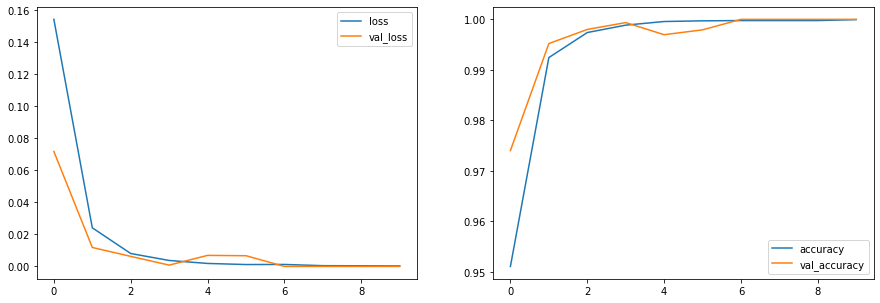

In [854]:
plot_history(d_history.history)
print_best_res(d_history.history)

### RNN model

In [870]:
%time
(train_data, val_data, test_data), (train_targets, val_targets, test_targets) = data_to_numpy(PATH, 
                                                                                            window = 10, 
                                                                                            step_slice = 5, 
                                                                                            random_state = RANDOM_STATE,
                                                                                            val_split=0.2,
                                                                                            test_split=0.2)

normalizer = Normalization(axis = -1)
normalizer.adapt(train_data)

train_data, val_data, test_data = normalizer(train_data), normalizer(val_data), normalizer(test_data)
train_targets, val_targets, test_targets = to_categorical(train_targets), to_categorical(val_targets), to_categorical(test_targets)

Wall time: 0 ns
Targets: ['badminton', 'basketball', 'cycling', 'football', 'skipping', 'tabletennis']
Loading data: badminton - target num: 0
	 Number of samples: 1990
Loading data: basketball - target num: 1
	 Number of samples: 1668
Loading data: cycling - target num: 2
	 Number of samples: 2363
Loading data: football - target num: 3
	 Number of samples: 1529
Loading data: skipping - target num: 4
	 Number of samples: 2780
Loading data: tabletennis - target num: 5
	 Number of samples: 2085


In [871]:
train_data.shape, val_data.shape, test_data.shape

(TensorShape([7449, 10, 9]),
 TensorShape([2483, 10, 9]),
 TensorShape([2483, 10, 9]))

In [872]:
RNN_model = models.Sequential()
RNN_model.add(layers.GRU(32, 
               dropout = 0.2, 
               recurrent_dropout = 0.2, 
               kernel_regularizer = regularizers.l2(0.0001), 
               return_sequences = True,
               input_shape = (train_data.shape[1], train_data.shape[2])))
RNN_model.add(layers.GRU(32, 
               dropout = 0.2, 
               recurrent_dropout = 0.2, 
               kernel_regularizer = regularizers.l2(0.0001)))
RNN_model.add(layers.Dense(6, activation = 'softmax'))

RNN_model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')

RNN_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 10, 32)            4128      
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_64 (Dense)             (None, 6)                 198       
Total params: 10,662
Trainable params: 10,662
Non-trainable params: 0
_________________________________________________________________


In [873]:
%%time
RNN_history = RNN_model.fit(train_data,
                       train_targets,
                       epochs = 10,
                       batch_size = 56,
                       validation_data = (val_data, val_targets))

Epoch 1/10
134/134 [==============================] - 12s 26ms/step - loss: 1.1690 - accuracy: 0.6136 - val_loss: 0.4641 - val_accuracy: 0.8437
Epoch 2/10
134/134 [==============================] - 3s 20ms/step - loss: 0.4648 - accuracy: 0.8374 - val_loss: 0.2590 - val_accuracy: 0.9013
Epoch 3/10
134/134 [==============================] - 2s 19ms/step - loss: 0.2914 - accuracy: 0.8989 - val_loss: 0.1690 - val_accuracy: 0.9460
Epoch 4/10
134/134 [==============================] - 3s 19ms/step - loss: 0.2171 - accuracy: 0.9296 - val_loss: 0.1249 - val_accuracy: 0.9613
Epoch 5/10
134/134 [==============================] - 3s 21ms/step - loss: 0.1747 - accuracy: 0.9411 - val_loss: 0.0871 - val_accuracy: 0.9770
Epoch 6/10
134/134 [==============================] - 2s 18ms/step - loss: 0.1452 - accuracy: 0.9537 - val_loss: 0.0910 - val_accuracy: 0.9726
Epoch 7/10
134/134 [==============================] - 3s 20ms/step - loss: 0.1166 - accuracy: 0.9648 - val_loss: 0.0629 - val_accuracy: 0.983

Best val_loss: 0.039 (8 epoch)
Best val_accuracy: 0.991 (8 epoch)


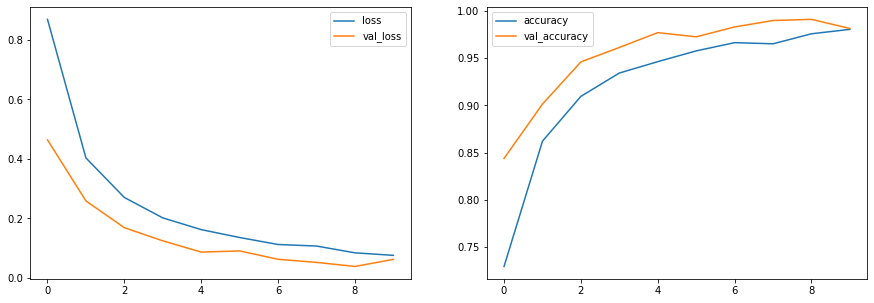

In [874]:
plot_history(RNN_history.history)
print_best_res(RNN_history.history)